[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/simple_detector_v2.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Предсказание

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/

    !kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
    !unzip gtsrb-german-traffic-sign.zip -d GTSRB/
    !rm gtsrb-german-traffic-sign.zip

    !kaggle datasets download mahadevkonar/belgiumts-dataset
    !unzip belgiumts-dataset.zip -d BelgiumTSC/
    !rm belgiumts-dataset.zip

    !kaggle datasets download dmitryyemelyanov/chinese-traffic-signs
    !unzip chinese-traffic-signs.zip -d ChineseTS/
    !rm chinese-traffic-signs.zip

    !cp /content/drive/MyDrive/TSR/train_anno_reduced_fp_detections.json .
    !cp /content/drive/MyDrive/TSR/val_anno_fp_detections.json .
    !cp /content/drive/MyDrive/TSR/train_anno_reduced_background.json .
    !cp /content/drive/MyDrive/TSR/val_anno_background.json .
    !cp /content/drive/MyDrive/TSR/RTSD_train_exp.pkl .
    !cp /content/drive/MyDrive/TSR/labels_names_map.json .

    !pip install fiftyone
    !pip install pandas==1.4.4

if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'



import json
import os
import numpy as np 
import pandas as pd 
import random
import time

#import cv2
import torch
import torch.nn as nn
#import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet152
#from torchvision.models.detection import FasterRCNN

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import matplotlib.patches as patches
from sklearn import metrics

#from pycocotools.coco import COCO
import fiftyone as fo

In [2]:
class RTSD_classifier_val(Dataset):
    def __init__(self, dataset_path):
        
        # Валидационный background
        with open(os.path.join(dataset_path, 'val_anno_background.json'), 'r') as read_file:
            background_anno = json.load(read_file)
        read_file.close()
        background_val = pd.DataFrame(background_anno.get('annotations'))
        anno_images = pd.DataFrame(background_anno.get('images'))
        background_val = background_val.merge(anno_images, left_on='image_id', right_on='id')[['file_name', 'width', 'height', 'bbox','category_id']]
        # Для класса background берем 100 сэмплов
        background_val = background_val.groupby('category_id', group_keys= False).apply(lambda x: x.sample(100))

        # Валидационный датасет
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno_json = json.load(read_file)
        read_file.close()
        anno_val = pd.DataFrame(val_anno_json.get('annotations'))
        anno_images = pd.DataFrame(val_anno_json.get('images'))
        anno_val = anno_val.merge(anno_images, left_on='image_id', right_on='id')[['file_name', 'width', 'height', 'bbox','category_id']]

        # Конкатенация датасетов
        anno_val = pd.concat((background_val, anno_val))

        # Приведение bbox из формата COCO (x1, y1, w, h) к виду (x1, y1, x2, y2)
        anno_val['bbox'] = anno_val['bbox'].apply (lambda x: [round(x[0]), round(x[1]), round(x[0]) + round(x[2]), round(x[1]) + round(x[3])])
        anno_val.reset_index(inplace=True)
        del anno_val['index']

        self.dataset_path = dataset_path
        self.dataset = anno_val
        self.transforms = transforms.Compose([transforms.Resize((224,224)),
                                              transforms.ToTensor()
                                              ])   

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, index):
        
        img_name = self.dataset.loc[index,'file_name']
        bbox = self.dataset.loc[index,'bbox']
        
        sign_w = bbox[2] - bbox[0]
        sign_h = bbox[3] - bbox[1]
        x1 = max(bbox[0] - round(max((sign_w*0.1), 5)), 0)
        y1 = max(bbox[1] - round(max((sign_h*0.1), 5)), 0)
        x2 = min(bbox[2] + round(max((sign_w*0.1), 5)), self.dataset.loc[index,'width'])
        y2 = min(bbox[3] + round(max((sign_h*0.1), 5)), self.dataset.loc[index,'height'])
        bbox = [x1, y1, x2, y2]

        img = Image.open(os.path.join(self.dataset_path, img_name))
        img = img.crop(bbox)
        img = self.transforms(img)

        label = torch.tensor(self.dataset.loc[index,'category_id'])
        return {'images':img, 'labels':label}

In [3]:
def plot_sign(dataset, index):
    item = dataset.__getitem__(index)
    img = item['images']
    target = item['labels']
    #img, target = test.__getitem__(index)
    img = img.permute(1, 2, 0).detach().numpy()
    img = img*255
    img = img.astype(np.uint8)
    fig, a = plt.subplots(1,1)
    #fig.set_size_inches(10,10)
    display(int(target.cpu().detach().numpy()))
    a.imshow(img)
    return None

In [4]:
def load_model_classifier(device, model_name, epoch, num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = resnet152(weights=None)
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #model.fc = nn.Sequential(nn.Linear(2048, 1024), nn.Linear(1024, num_classes))
    #model.fc = nn.Sequential(nn.Linear(2048, num_classes))
    for param in model.fc.parameters():
        param.requires_grad = True

    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

In [5]:
def val(val_dataloader, epoch):
    len_dataloader = len(val_dataloader)

    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []
    
    model.eval()

    for batch_idx, data in enumerate(val_dataloader):
        
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        with torch.no_grad():
            
            output = model(images)
            loss = loss_function(output, targets)

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader}  is having validation accuracy of {(100*correct/total)}")

        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

    val_accuracy = metrics.accuracy_score(y_true, y_pred)
    val_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    val_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    val_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")

    return val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted

Гиперпараметры

In [3]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'

batch_size = 8
num_classes = 156

#model_name = 'resnet152_default_sgd_005_sh_3_01'
#model_name = 'resnet152_augmented_alb_adam_001_sh_1_09'
#model_name = 'resnet152_augmented_tv'
#model_name = 'resnet152_sampled_full_mix'
model_name = 'resnet152_add_signs_alb_adam_001_sh_1_09'
max_epochs = 29

device

'cuda:0'

In [24]:
# Смотрим на поля чекпойнта
epoch = 10
checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'), map_location=device)
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'losses_train', 'losses_val', 'accuracies_train', 'accuracies_val', 'f1_micros_train', 'f1_micros_val', 'f1_macros_train', 'f1_macros_val', 'f1_weighteds_train', 'f1_weighteds_val'])

In [117]:
'''torch.save({'epoch': epoch,
                    # Обращаем внимание на поля, которые нужно пересохранить
                    'epoch': checkpoint['epoch'],
                    'model_state_dict': checkpoint['model_state_dict'],
                    'optimizer_state_dict': checkpoint['optimizer_state_dict'],
                    'lr_scheduler_state_dict': '',
                    'losses_train': checkpoint['losses_train'],
                    'losses_val': checkpoint['losses_val'],
                    }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))'''

In [118]:
val_dataset = RTSD_classifier_val(dataset_path)
val_data_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            )

# Загрузка словарей с лоссами
val_accuracies = []
val_f1_micros = []
val_f1_macros = []
val_f1_weighteds = []

try:
    for epoch in range(max_epochs+1):
        
        start = time.time()

        # Загружаем модель
        model = load_model_classifier(device, model_name, epoch, num_classes).to(device)
        loss_function = nn.CrossEntropyLoss()

        # Загружаем чекпойнт
        checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'), map_location=device)   
        val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted = val(val_data_loader, epoch)

        val_accuracies.append(val_accuracy)
        val_f1_micros.append(val_f1_micro)
        val_f1_macros.append(val_f1_macro)
        val_f1_weighteds.append(val_f1_weighted)
        
        torch.save({'epoch': epoch,
                    # Обращаем внимание на поля, которые нужно пересохранить
                    'model_state_dict': checkpoint['model_state_dict'],
                    'optimizer_state_dict': checkpoint['optimizer_state_dict'],
                    'lr_scheduler_state_dict': checkpoint['lr_scheduler_state_dict'],
                    'losses_train': checkpoint['losses_train'],
                    'losses_val': checkpoint['losses_val'],
                    #'accuracies_train': checkpoint['accuracies_train'],
                    #'accuracies_val': checkpoint['accuracies_val'],

                    # Новые поля
                    'accuracies_val_post': val_accuracies,
                    'f1_micros_val_post': val_f1_micros,
                    'f1_macros_val_post': val_f1_macros,
                    'f1_weighteds_val_post': val_f1_weighteds,
                    }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
        torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на валидацию {epoch} эпохи")

except KeyboardInterrupt:
    print('Прервано пользователем')

Epoch #0. Batch Id 0/281  is having validation accuracy of 18.75
Epoch #0. Batch Id 1/281  is having validation accuracy of 21.875
Epoch #0. Batch Id 2/281  is having validation accuracy of 19.791666666666668
Epoch #0. Batch Id 3/281  is having validation accuracy of 31.25
Epoch #0. Batch Id 4/281  is having validation accuracy of 38.125
Epoch #0. Batch Id 5/281  is having validation accuracy of 43.75
Epoch #0. Batch Id 6/281  is having validation accuracy of 48.660714285714285
Epoch #0. Batch Id 7/281  is having validation accuracy of 51.171875
Epoch #0. Batch Id 8/281  is having validation accuracy of 52.083333333333336
Epoch #0. Batch Id 9/281  is having validation accuracy of 53.125
Epoch #0. Batch Id 10/281  is having validation accuracy of 55.11363636363637
Epoch #0. Batch Id 11/281  is having validation accuracy of 56.510416666666664
Epoch #0. Batch Id 12/281  is having validation accuracy of 56.97115384615385
Epoch #0. Batch Id 13/281  is having validation accuracy of 58.035714

In [9]:
checkpoint['optimizer_state_dict']

{'state': {0: {'momentum_buffer': tensor([[-2.6663e-02, -3.2976e-02, -1.0613e-01,  ..., -2.7240e-02,
            -3.2839e-02, -4.4423e-03],
           [ 1.1277e-02,  1.2755e-02,  3.3251e-02,  ...,  1.1642e-02,
             3.0939e-03,  7.6657e-03],
           [ 3.2790e-02,  8.7684e-03, -4.3117e-02,  ..., -2.6057e-03,
             8.9394e-03,  1.8018e-02],
           ...,
           [ 4.7776e-04,  3.3879e-04,  5.1141e-04,  ...,  3.4984e-04,
             2.1195e-04,  3.1073e-04],
           [ 6.0499e-04,  3.8802e-04,  5.8535e-04,  ...,  3.1059e-04,
             2.6504e-04,  2.2930e-04],
           [ 1.9879e-04,  5.5718e-05,  1.4475e-04,  ...,  8.3921e-05,
             3.5139e-05,  2.9214e-05]], device='cuda:0')},
  1: {'momentum_buffer': tensor([-8.0850e-02,  3.2471e-02,  5.0591e-04,  1.7157e-02,  8.3429e-02,
            2.6960e-02,  3.8014e-03, -2.8195e-01, -8.2241e-02, -1.5493e-03,
            1.3104e-02,  8.7835e-04,  1.1314e-02, -9.0485e-03,  8.8150e-03,
            3.1925e-02, -7.47

In [8]:
checkpoint['lr_scheduler_state_dict']       

{'step_size': 3,
 'gamma': 0.1,
 'base_lrs': [0.005],
 'last_epoch': 30,
 'verbose': False,
 '_step_count': 31,
 '_get_lr_called_within_step': False,
 '_last_lr': [5.000000000000003e-13]}

In [ ]:
#int(classifier(sign.unsqueeze(0)).data.max(1,keepdim=True)[1][0][0])      # можно подумать как вытащить уверенность модели  
#np.argmax(classifier(sign.unsqueeze(0)).data)      альтернатива

In [ ]:
val_f1_micros = []
checkpoint['f1_micros_val_post']
#checkpoint['f1_macros_val_post']
for i in range(len(checkpoint['f1_micros_val_post'])):
    val_f1_micros.append(float(checkpoint['f1_micros_val_post'][i]))

val_f1_macros = []
for i in range(len(checkpoint['f1_macros_val_post'])):
    val_f1_macros.append(float(checkpoint['f1_macros_val_post'][i]))

In [25]:
train_f1_micros = []
for i in range(len(checkpoint['f1_micros_train'])):
    train_f1_micros.append(float(checkpoint['f1_micros_train'][i]))

val_f1_micros = []
for i in range(len(checkpoint['f1_micros_val'])):
    val_f1_micros.append(float(checkpoint['f1_micros_val'][i]))


train_f1_macros = []
for i in range(len(checkpoint['f1_macros_train'])):
    train_f1_macros.append(float(checkpoint['f1_macros_train'][i]))

val_f1_macros = []
for i in range(len(checkpoint['f1_macros_val'])):
    val_f1_macros.append(float(checkpoint['f1_macros_val'][i]))

In [ ]:
'f1_micros_train', 'f1_micros_val', 'f1_macros_train', 'f1_macros_val', 'f1_weighteds_train', 'f1_weighteds_val'])

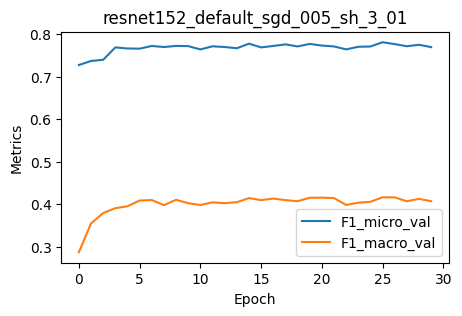

In [137]:
%matplotlib inline
fig, ax = plt.subplots()
#ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
#ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_macro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
fig.set_size_inches(5, 3)
plt.show()

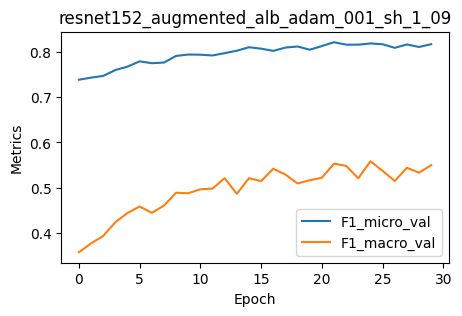

In [141]:
%matplotlib inline
fig, ax = plt.subplots()
#ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
#ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_macro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
fig.set_size_inches(5, 3)
plt.show()

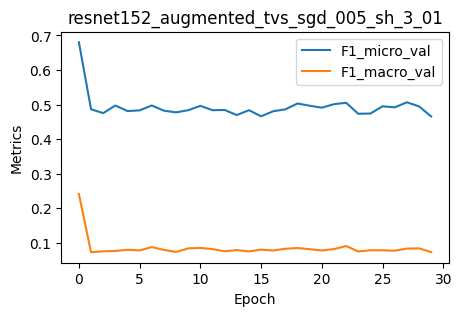

In [12]:
%matplotlib inline
fig, ax = plt.subplots()
#ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
#ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_macro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
fig.set_size_inches(5, 3)
plt.show()

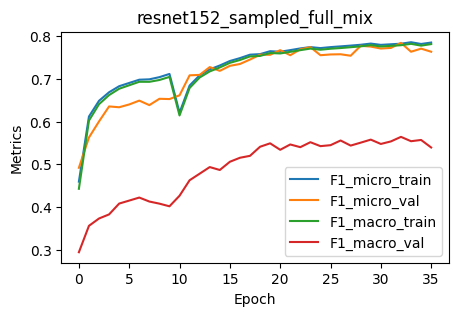

In [21]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_macro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
fig.set_size_inches(5, 3)
plt.show()

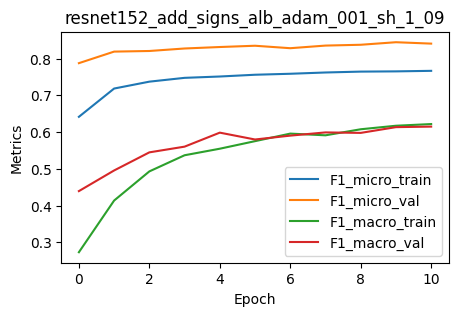

In [26]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_macro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
fig.set_size_inches(5, 3)
plt.show()

In [27]:
val_f1_micros

[0.7875306714253848,
 0.8189828240017847,
 0.8206558108409547,
 0.8274592906535801,
 0.8314744590675887,
 0.8349319652018737,
 0.828240017845193,
 0.8353780950256524,
 0.8376087441445462,
 0.8445237564131162,
 0.840731652910997]

In [28]:
val_f1_macros

[0.4392255765810162,
 0.49542904490095535,
 0.5446965923278962,
 0.5602592589787959,
 0.5983650422609963,
 0.5797127370441648,
 0.5902525953740321,
 0.5989978536964936,
 0.5976830158235589,
 0.6133378995226205,
 0.6148103463633571]

In [9]:
checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_resnet50_all_classes_5.pth'), map_location=device)
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'lr_scheduler_state_dict', 'losses_train', 'losses_val'])

In [11]:
train_losses = []
#checkpoint['f1_macros_val_post']
for i in range(len(checkpoint['losses_train'])):
    train_losses.append(float(checkpoint['losses_train'][i]))

val_losses = []
for i in range(len(checkpoint['losses_val'])):
    val_losses.append(float(checkpoint['losses_val'][i]))

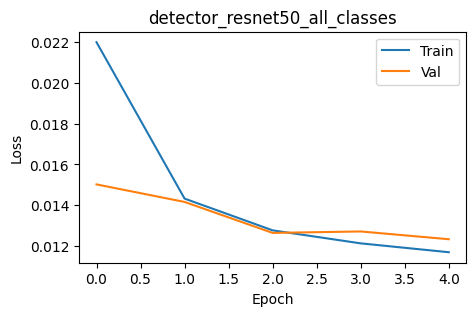

In [13]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set_title('detector_resnet50_all_classes')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
fig.set_size_inches(5, 3)
plt.show()

In [6]:
checkpoint = torch.load(os.path.join(checkpoints_path, 'classifier', f'chkpt_classifier_resnet152_sampled_full_mix_35.pth'), map_location=device)
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'lr_scheduler_state_dict', 'losses_train', 'losses_val', 'accuracies_train', 'accuracies_val', 'f1_micros_train', 'f1_micros_val', 'f1_macros_train', 'f1_macros_val', 'f1_weighteds_train', 'f1_weighteds_val'])

In [8]:
val_f1_micros = []
#checkpoint['f1_macros_val_post']
for i in range(len(checkpoint['f1_micros_val'])):
    val_f1_micros.append(float(checkpoint['f1_micros_val'][i]))

val_f1_macros = []
for i in range(len(checkpoint['f1_macros_val'])):
    val_f1_macros.append(float(checkpoint['f1_macros_val'][i]))

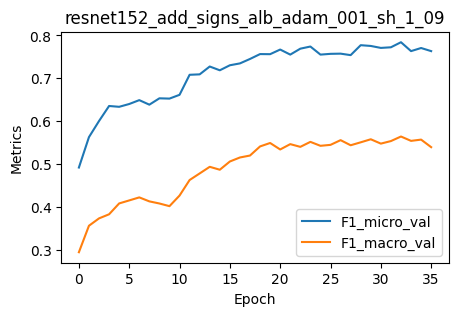

In [9]:
%matplotlib inline
fig, ax = plt.subplots()
#ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
#ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_macro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
fig.set_size_inches(5, 3)
plt.show()

In [17]:
for i in range(len(checkpoint['f1_micros_val'])):
    if checkpoint['f1_micros_val'][i] == max(checkpoint['f1_micros_val']):
        print(i)
        print(checkpoint['f1_micros_val'][i])
        print(checkpoint['f1_macros_val'][i])

32
0.7841846977470445
0.5642622655233874


In [18]:
checkpoint = torch.load(os.path.join(checkpoints_path, 'classifier', f'chkpt_classifier_resnet152_add_signs_alb_adam_001_sh_1_09_10.pth'), map_location=device)
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'losses_train', 'losses_val', 'accuracies_train', 'accuracies_val', 'f1_micros_train', 'f1_micros_val', 'f1_macros_train', 'f1_macros_val', 'f1_weighteds_train', 'f1_weighteds_val'])

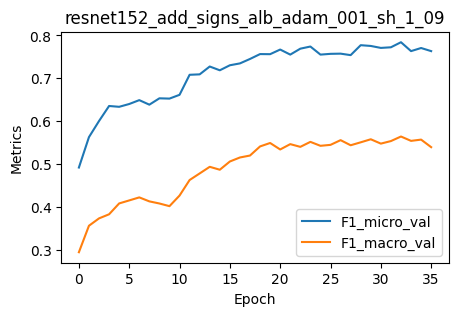

In [19]:
%matplotlib inline
fig, ax = plt.subplots()
#ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
#ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_macro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
fig.set_size_inches(5, 3)
plt.show()

In [20]:
for i in range(len(checkpoint['f1_micros_val'])):
    if checkpoint['f1_micros_val'][i] == max(checkpoint['f1_micros_val']):
        print(i)
        print(checkpoint['f1_micros_val'][i])
        print(checkpoint['f1_macros_val'][i])

9
0.8445237564131162
0.6133378995226205


Сводная таблица с f1 для разных аугментаций torchvision

In [47]:
checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_resnet152_test_with_bg_v100_tvs_default_adam_001_9.pth'), map_location=device)
checkpoint['f1_micros_val']

[0.8099909788001805,
 0.8342354533152909,
 0.8415651781686965,
 0.8534055029318899,
 0.8584799278304014,
 0.8570139828597203,
 0.8603969327920613,
 0.8598331078033379,
 0.8543076229138475,
 0.8548714479025711]

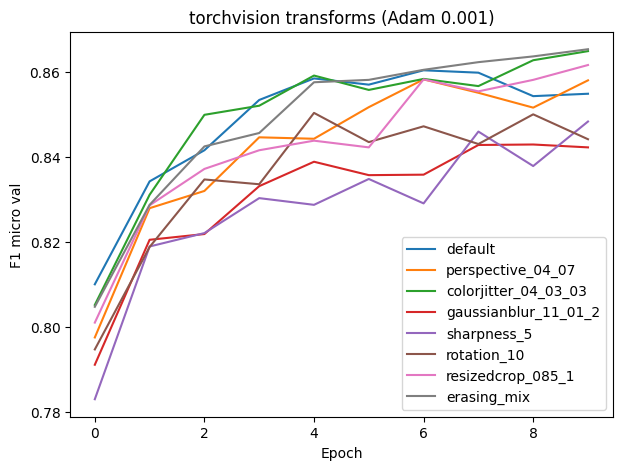

In [52]:
# Везде Adam 0.001, в background 100 сэмплов
f1_micro_val_tvs_default = [0.8099909788001805, 0.8342354533152909, 0.8415651781686965, 0.8534055029318899, 0.8584799278304014, 0.8570139828597203, 0.8603969327920613, 0.8598331078033379, 0.8543076229138475, 0.8548714479025711]
f1_micro_val_tvs_perspective_04_07 = [0.7974740640505187, 0.8279206134415877, 0.8319801533603969, 0.8446098331078034, 0.8442715381145692, 0.8517140279657196, 0.8582543978349121, 0.8550969778980605, 0.8516012629679748, 0.8580288678394227]
f1_micro_val_tvs_colorjitter_04_03_03 = [0.8051420838971584, 0.8310780333784393, 0.8499097880018043, 0.8520523229589535, 0.8591565178168695, 0.8557735678845286, 0.8583671628326568, 0.8566756878664863, 0.8627649977447001, 0.8649075327018494]
f1_micro_val_tvs_gaussianblur_11_01_2 = [0.7910464591790708, 0.8204781235904374, 0.821831303563374, 0.833107803337844, 0.8388588182228236, 0.835701398285972, 0.8358141632837167, 0.8428055931438881, 0.8429183581416329, 0.8422417681551647]
f1_micro_val_tvs_sharpness_5 = [0.7829273793414524, 0.8188994136220117, 0.8220568335588633, 0.8302886783942265, 0.8287099684258006, 0.8347992783040145, 0.8290482634190347, 0.8459630130807397, 0.8378439332431213, 0.8483310780333785]
f1_micro_val_tvs_rotation_10 = [0.7946549391069012, 0.818786648624267, 0.8346865133062698, 0.8335588633288229, 0.8503608479927831, 0.8434821831303564, 0.8472034280559314, 0.8430311231393776, 0.850022552999549, 0.8441587731168245]
f1_micro_val_tvs_resizedcrop_085_1 = [0.8009697789806045, 0.8285972034280561, 0.8371673432566531, 0.8415651781686965, 0.8438204781235904, 0.8422417681551647, 0.8582543978349121, 0.8554352728912945, 0.8581416328371674, 0.8616373477672531]
f1_micro_val_tvs_erasing_mix = [0.8046910239061795, 0.8287099684258006, 0.8424672981506539, 0.8456247180875056, 0.8575778078484438, 0.8581416328371674, 0.860509697789806, 0.8623139377537212, 0.8636671177266576, 0.8653585926928282]

%matplotlib inline
fig, ax = plt.subplots()
ax.plot(f1_micro_val_tvs_default, label='default')
ax.plot(f1_micro_val_tvs_perspective_04_07, label='perspective_04_07')
ax.plot(f1_micro_val_tvs_colorjitter_04_03_03, label='colorjitter_04_03_03')
ax.plot(f1_micro_val_tvs_gaussianblur_11_01_2, label='gaussianblur_11_01_2')
ax.plot(f1_micro_val_tvs_sharpness_5, label='sharpness_5')
ax.plot(f1_micro_val_tvs_rotation_10, label='rotation_10')
ax.plot(f1_micro_val_tvs_resizedcrop_085_1, label='resizedcrop_085_1')
ax.plot(f1_micro_val_tvs_erasing_mix, label='erasing_mix')
ax.set_title("torchvision transforms (Adam 0.001)")
ax.set(xlabel='Epoch', ylabel='F1 micro val')
ax.legend()
fig.set_size_inches(7, 5)
plt.show()

In [50]:
checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_resnet152_test_with_bg_v100_tvs_default_adam_001_9.pth'), map_location=device)
checkpoint['f1_macros_val']

[0.47753593063727634,
 0.5402081978600969,
 0.5924755677378537,
 0.5927924913520914,
 0.6241098565896814,
 0.6378429092414437,
 0.6400543634416243,
 0.6387173601215189,
 0.6534135087659861,
 0.6408127238327912]

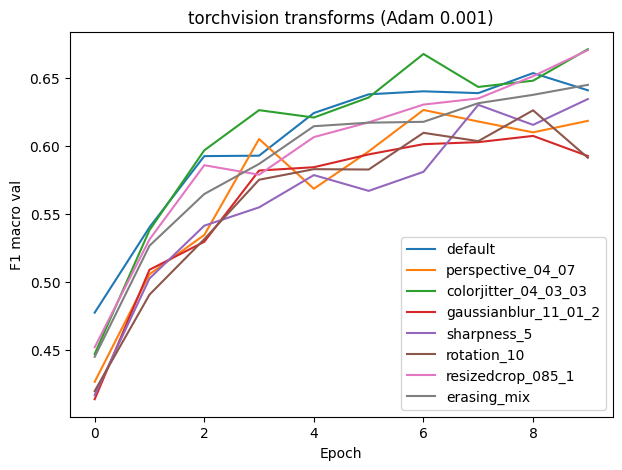

In [53]:
# Везде Adam 0.001, в background 100 сэмплов
f1_macro_val_tvs_default = [0.47753593063727634, 0.5402081978600969, 0.5924755677378537, 0.5927924913520914, 0.6241098565896814, 0.6378429092414437, 0.6400543634416243, 0.6387173601215189, 0.6534135087659861, 0.6408127238327912]
f1_macro_val_tvs_perspective_04_07 = [0.4267558766716525, 0.5057410841351803, 0.5345668076722392, 0.6050370283196991, 0.5685269905295972, 0.595914779263006, 0.6263731695072033, 0.6178861525031408, 0.6099206435221, 0.6183695755920581]
f1_macro_val_tvs_colorjitter_04_03_03 = [0.4471983537827319, 0.5380813210197497, 0.5967307226436479, 0.626213941092602, 0.6208006494533473, 0.6355241914291176, 0.6674710380605475, 0.643263821447888, 0.6478523470052815, 0.6709575907951353]
f1_macro_val_tvs_gaussianblur_11_01_2 = [0.41397299960626105, 0.509042695948534, 0.5295819728930312, 0.5818807844366444, 0.5843243352604607, 0.5937338436229631, 0.601248108556618, 0.602725438655553, 0.607310894462018, 0.5925330860889455]
f1_macro_val_tvs_sharpness_5 = [0.4170528321784365, 0.5026307579324033, 0.5413931163540086, 0.5548468965491905, 0.5785456754123742, 0.5669558830728761, 0.5809343760493532, 0.630116329572596, 0.6154211162353219, 0.6343752797493177]
f1_macro_val_tvs_rotation_10 = [0.4199348730558276, 0.4907701930274467, 0.531482703865444, 0.5751225005374656, 0.5828873925832903, 0.5826330877157982, 0.6095717984873773, 0.603462002356952, 0.6261057729951599, 0.591249847139147]
f1_macro_val_tvs_resizedcrop_085_1 = [0.45212130005590967,  0.5312790516012814, 0.5857832782738376, 0.5788223890402138, 0.6064348562194642, 0.6172845893215396, 0.6303096217737733, 0.6348230617364501, 0.6511512096552028, 0.670260053850013]
f1_macro_val_tvs_erasing_mix = [0.44510025805474757, 0.5266782359908755, 0.5646461758808454, 0.5867452638021049, 0.614428644897562, 0.6170205497666275, 0.6176441873517029, 0.6313348422441384, 0.6374650266905495, 0.6447962069770309]

%matplotlib inline
fig, ax = plt.subplots()
ax.plot(f1_macro_val_tvs_default, label='default')
ax.plot(f1_macro_val_tvs_perspective_04_07, label='perspective_04_07')
ax.plot(f1_macro_val_tvs_colorjitter_04_03_03, label='colorjitter_04_03_03')
ax.plot(f1_macro_val_tvs_gaussianblur_11_01_2, label='gaussianblur_11_01_2')
ax.plot(f1_macro_val_tvs_sharpness_5, label='sharpness_5')
ax.plot(f1_macro_val_tvs_rotation_10, label='rotation_10')
ax.plot(f1_macro_val_tvs_resizedcrop_085_1, label='resizedcrop_085_1')
ax.plot(f1_macro_val_tvs_erasing_mix, label='erasing_mix')
ax.set_title("torchvision transforms (Adam 0.001)")
ax.set(xlabel='Epoch', ylabel='F1 macro val')
ax.legend()
fig.set_size_inches(7, 5)
plt.show()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_macro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
fig.set_size_inches(5, 3)
plt.show()